In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from scipy.optimize import minimize, minimize_scalar

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def plot_joukowsky(R, x_center, y_center):
    """Generate Joukowsky airfoil coordinates."""
    n_points = 400
    theta = np.linspace(0, 2 * np.pi, n_points)
    w = (x_center + R * np.cos(theta)) + 1j * (y_center + R * np.sin(theta))
    a = R
    z = w + (a**2) / w
    return z.real, z.imag

def reflect(points, angle_deg):
    """Reflect points across a line through origin at given angle."""
    theta = np.radians(angle_deg)
    cos_theta = np.cos(-theta)
    sin_theta = np.sin(-theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    cos_theta_inv = np.cos(theta)
    sin_theta_inv = np.sin(theta)
    rotation_matrix_inv = np.array([[cos_theta_inv, -sin_theta_inv], [sin_theta_inv, cos_theta_inv]])
    reflected_points = []
    for p in points:
        p_rotated = rotation_matrix @ p
        p_reflected_rotated = np.array([p_rotated[0], -p_rotated[1]])
        p_reflected = rotation_matrix_inv @ p_reflected_rotated
        reflected_points.append(p_reflected)
    return np.array(reflected_points)

def rotate(points, angle_deg, center=(0, 0)):
    """Rotate points around a center."""
    angle_rad = np.radians(angle_deg)
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                  [np.sin(angle_rad),  np.cos(angle_rad)]])
    return (points - center) @ R.T + center

# ============================================================================
# MAIN SHAPE GENERATION
# ============================================================================

# Parameters
r1 = 1.0      # Inner arc radius
r2 = 1.2      # Outer arc radius
R = 0.05      # Rounding corner radius
R_joint = 0.3 # Joint rounding radius

# Key points
p1 = np.array([-0.7, np.sqrt(r1**2 - 0.7**2)])
p2 = np.array([-0.7, np.sqrt(r2**2 - 0.7**2)])
p3 = np.array([-0.1, np.sqrt(r1**2 - 0.1**2)])
p4 = np.array([-0.1, 0])

# Generate base segments
theta_outer = np.linspace(np.pi / 2, np.arccos(-0.7 / r2), 100)
arc1_pts = np.array([(r2 * np.cos(t), r2 * np.sin(t)) for t in theta_outer])
seg2_pts = np.array([p2, p1])
theta_inner = np.linspace(np.arccos(-0.7 / r1), np.arccos(-0.1 / r1), 100)
arc3_pts = np.array([(r1 * np.cos(t), r1 * np.sin(t)) for t in theta_inner])
seg4_pts = np.array([p3, p4])

# ============================================================================
# ROUNDED CORNERS (Inner corner: arc1 -> seg2)
# ============================================================================

def objective_inner(center):
    dists = []
    dist_seg = Point(center).distance(LineString(seg2_pts))
    dists.append((dist_seg - R)**2)
    d_arc = np.min(np.linalg.norm(arc1_pts - center, axis=1))
    dists.append((d_arc - R)**2)
    origin_dist = np.linalg.norm(center)
    if origin_dist > r2 - R:
        dists.append(10 * (origin_dist - (r2 - R))**2)
    return sum(dists)

res_inner = minimize(objective_inner, [-0.7 + R, 1.0], method='Nelder-Mead')
circle_center_inner = res_inner.x
closest_arc_pt_inner = arc1_pts[np.argmin(np.linalg.norm(arc1_pts - circle_center_inner, axis=1))]
closest_seg_pt_inner = np.array(LineString(seg2_pts).interpolate(
    LineString(seg2_pts).project(Point(circle_center_inner))).coords[0])

vec_start = closest_arc_pt_inner - circle_center_inner
vec_end = closest_seg_pt_inner - circle_center_inner
angle_start = np.arctan2(vec_start[1], vec_start[0])
angle_end = np.arctan2(vec_end[1], vec_end[0])
if angle_end < angle_start:
    angle_end += 2 * np.pi
arc_connection_theta = np.linspace(angle_start, angle_end, 100)
arc_connection_inner = np.array([circle_center_inner + R * np.array([np.cos(a), np.sin(a)]) 
                                 for a in arc_connection_theta])

# ============================================================================
# ROUNDED CORNERS (Outer corner: seg2 -> arc3)
# ============================================================================

def objective_outer(center):
    dists = []
    dist_seg = Point(center).distance(LineString(seg2_pts))
    dists.append((dist_seg - R)**2)
    d_arc = np.min(np.linalg.norm(arc3_pts - center, axis=1))
    dists.append((d_arc - R)**2)
    origin_dist = np.linalg.norm(center)
    if origin_dist < r1 + R:
        dists.append(1000 * (r1 + R - origin_dist)**2)
    return sum(dists)

res_outer = minimize(objective_outer, [-0.65, 0.8], method='Nelder-Mead')
circle_center_outer = res_outer.x
closest_arc3_pt = arc3_pts[np.argmin(np.linalg.norm(arc3_pts - circle_center_outer, axis=1))]
closest_seg2_pt = np.array(LineString(seg2_pts).interpolate(
    LineString(seg2_pts).project(Point(circle_center_outer))).coords[0])

vec_start = closest_seg2_pt - circle_center_outer
vec_end = closest_arc3_pt - circle_center_outer
angle_start = np.arctan2(vec_start[1], vec_start[0])
angle_end = np.arctan2(vec_end[1], vec_end[0])
if angle_end < angle_start:
    angle_start -= 2 * np.pi
arc_connection_theta = np.linspace(angle_end, angle_start, 100)
arc_connection_outer = np.array([circle_center_outer + R * np.array([np.cos(a), np.sin(a)]) 
                                 for a in arc_connection_theta])[::-1]

# ============================================================================
# ROUNDED CORNERS (Lower corner: arc3 -> seg4)
# ============================================================================

line_seg4 = LineString(seg4_pts)

def objective_x(cx):
    return abs(Point([cx, 0.3]).distance(line_seg4.interpolate(
        line_seg4.project(Point([cx, 0.3])))) - R)

res_x = minimize_scalar(objective_x, bounds=(-0.3, 0.3), method='bounded')
x0 = res_x.x

def objective_y(cy):
    center = np.array([x0, cy])
    return abs(np.min(np.linalg.norm(arc3_pts - center, axis=1)) - R)

res_y = minimize_scalar(objective_y, bounds=(0.3, 1.0), method='bounded')
circle_center_low = np.array([x0, res_y.x])

closest_arc_low = arc3_pts[np.argmin(np.linalg.norm(arc3_pts - circle_center_low, axis=1))]
closest_seg_low = np.array(line_seg4.interpolate(
    line_seg4.project(Point(circle_center_low))).coords[0])

vec_start = closest_arc_low - circle_center_low
vec_end = closest_seg_low - circle_center_low
angle_start = np.arctan2(vec_start[1], vec_start[0])
angle_end = np.arctan2(vec_end[1], vec_end[0])
if angle_start < angle_end:
    angle_end -= 2 * np.pi
arc_connection_theta = np.linspace(angle_start, angle_end, 100)
arc_connection_low = np.array([circle_center_low + R * np.array([np.cos(a), np.sin(a)]) 
                               for a in arc_connection_theta])

# ============================================================================
# ASSEMBLE FULL CONTOUR
# ============================================================================

index_of_closest_arc_pt_inner = np.argmin(np.linalg.norm(arc1_pts - closest_arc_pt_inner, axis=1))
arc1_start_to_inner_contact = arc1_pts[:index_of_closest_arc_pt_inner + 1]
seg_inner_to_outer = np.array([closest_seg_pt_inner, closest_seg2_pt])
index_of_closest_arc3_outer = np.argmin(np.linalg.norm(arc3_pts - closest_arc3_pt, axis=1))
index_of_closest_arc3_low = np.argmin(np.linalg.norm(arc3_pts - closest_arc_low, axis=1))
arc3_outer_to_lower_contact = arc3_pts[index_of_closest_arc3_outer : index_of_closest_arc3_low + 1]
seg4_to_end = np.array([closest_seg_low, seg4_pts[1]])

full_contour = np.vstack([
    arc1_start_to_inner_contact,
    arc_connection_inner[1:],
    seg_inner_to_outer[1:],
    arc_connection_outer[1:],
    arc3_outer_to_lower_contact[1:],
    arc_connection_low[1:],
])

# Create reflected version
full_contour_reflected = reflect(full_contour, 150)
seg4 = seg4_to_end
seg4_r = reflect(seg4, 150)

# ============================================================================
# ROUNDED JOINT between seg4 and seg4_r
# ============================================================================

A = seg4[0]
B = seg4[1]  # The corner point
C = seg4_r[0]

u = (A - B) / np.linalg.norm(A - B)
v = (C - B) / np.linalg.norm(C - B)

theta = np.arccos(np.clip(np.dot(u, v), -1.0, 1.0)) / 2
bisector = u + v
bisector /= np.linalg.norm(bisector)

d = R_joint / np.sin(theta)
circle_center = B + d * bisector

normal_to_AB = np.array([-u[1], u[0]])
normal_to_BC = np.array([v[1], -v[0]])

contact_AB = circle_center + R_joint * (-normal_to_AB)
contact_BC = circle_center + R_joint * (-normal_to_BC)

angle1 = np.arctan2(*(contact_AB - circle_center)[::-1])
angle2 = np.arctan2(*(contact_BC - circle_center)[::-1])

if angle1 < angle2:
    angle2 -= 2 * np.pi

arc_angles = np.linspace(angle2, angle1, 100)
arc_x = circle_center[0] + R_joint * np.cos(arc_angles)
arc_y = circle_center[1] + R_joint * np.sin(arc_angles)

# Build the rounded segment
joint1 = np.array([seg4[0], [contact_AB[0], contact_AB[1]]])
joint2 = np.array([[contact_BC[0], contact_BC[1]], seg4_r[0]])
arc_joint = np.vstack([arc_x, arc_y]).T
arc_joint_flipped = arc_joint[::-1]
finale1 = np.vstack([joint1, arc_joint_flipped, joint2])

print("✓ Shape generation complete!")

✓ Shape generation complete!


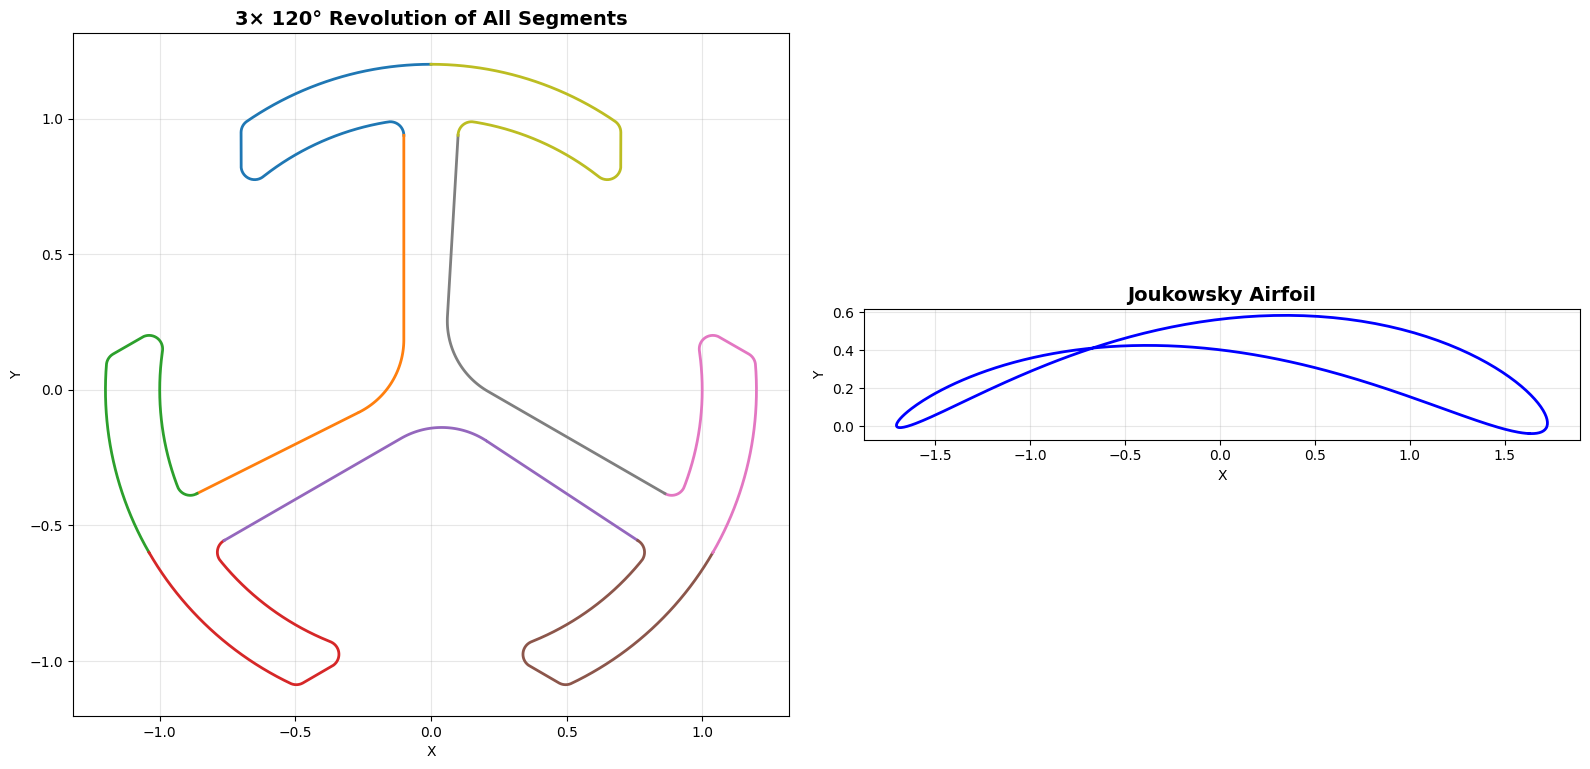


✓ Visualization complete!

Generated 9 segments in revolution pattern
Joukowsky airfoil has 400 points


In [3]:
# ============================================================================
# PLOT: 3× 120° Revolution of All Segments + Joukowsky Airfoil
# ============================================================================

# Generate Joukowsky airfoil
joukowsky_x, joukowsky_y = plot_joukowsky(R=0.85, x_center=-0.1, y_center=0.23)

# Prepare base paths for revolution
base_paths = [full_contour, finale1, full_contour_reflected]
paths_to_plot = []

# For each rotation (0°, 120°, 240°), rotate each base path
for angle in [0, 120, 240]:
    for path in base_paths:
        rotated_path = rotate(path, angle, center=(0, 0))
        paths_to_plot.append(rotated_path)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: 3× 120° Revolution Pattern
for i, path in enumerate(paths_to_plot):
    ax1.plot(path[:, 0], path[:, 1], '-', linewidth=2, label=f"Segment {i+1}")

ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_title("3× 120° Revolution of All Segments", fontsize=14, fontweight='bold')
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# Plot 2: Joukowsky Airfoil
ax2.plot(joukowsky_x, joukowsky_y, 'b-', linewidth=2)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_title("Joukowsky Airfoil", fontsize=14, fontweight='bold')
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"\nGenerated {len(paths_to_plot)} segments in revolution pattern")
print(f"Joukowsky airfoil has {len(joukowsky_x)} points")